Running LightGBM Depth Analysis...


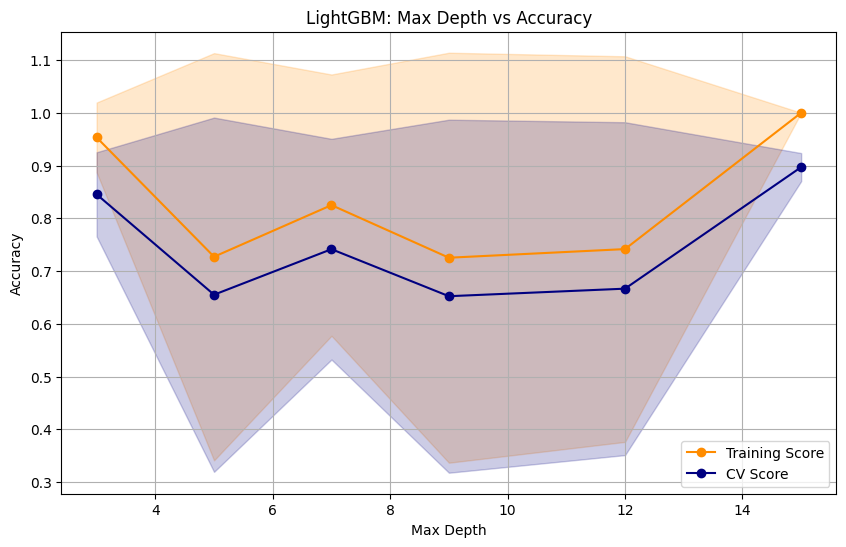

Generating Calibration Curve...


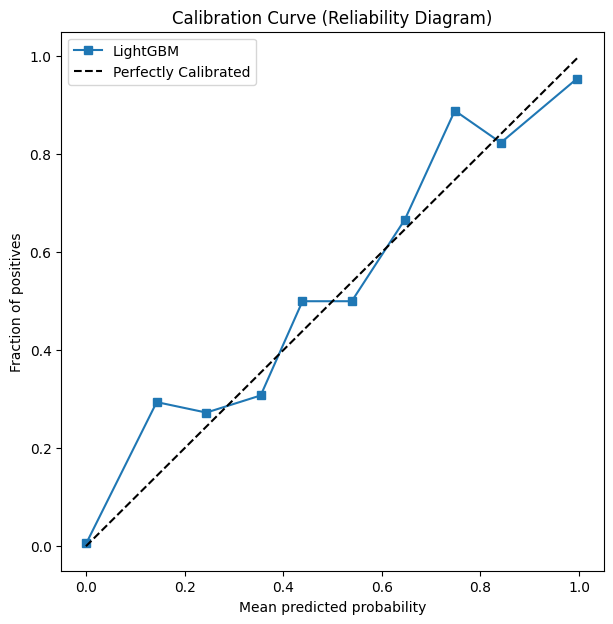

Q1: Does LightGBM need Frequency features?
Time-Only Accuracy: 0.9054
Freq-Only Accuracy: 0.8833
Combined Accuracy: 0.9200
Do Time-only and Freq-only models make the SAME mistakes?
Agreement between Time and Freq Models: 68.66%


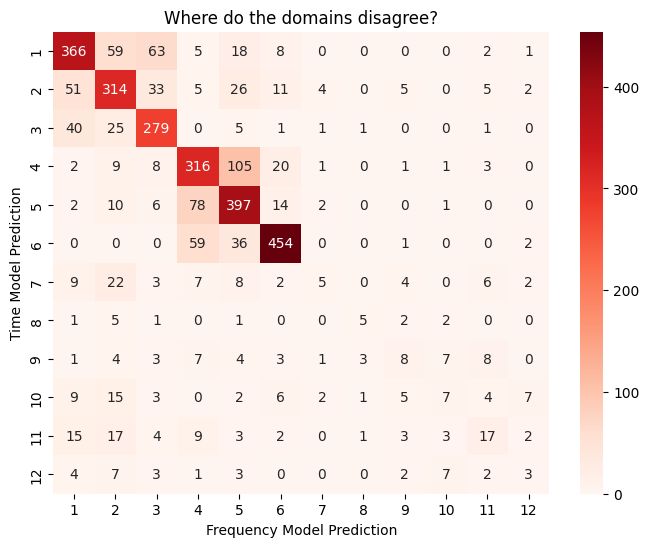

In [2]:
# --- IMPORTS & DATA LOADING ---
from tabnanny import verbose
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.calibration import calibration_curve
import re

train_df = pd.read_csv('../../data/activity_train.csv')
test_df = pd.read_csv('../../data/activity_test.csv')

# LightGBM crashes if column names have special characters like () or ,
# We must clean them here
train_df.columns = [re.sub(r'[(),-]', '_', col) for col in train_df.columns]
test_df.columns = [re.sub(r'[(),-]', '_', col) for col in test_df.columns]

le = LabelEncoder()

X_train = train_df.drop(columns=['activity', 'subject'], errors='ignore')
y_train = le.fit_transform(train_df['activity'])
X_test = test_df.drop(columns=['activity', 'subject'], errors='ignore')
y_test = le.fit_transform(test_df['activity'])

# --- PART 1: DEEP DIVE (Validation Curve) ---
print("Running LightGBM Depth Analysis...")
# (This is the code that generated that cool graph we discussed)
depth_range = [3, 5, 7, 9, 12, 15]
train_scores, test_scores = validation_curve(
    LGBMClassifier(n_estimators=100, verbose=-1, random_state=42), 
    X_train, y_train, 
    param_name="max_depth", param_range=depth_range,
    cv=3, scoring="accuracy", n_jobs=-1
)

# Calculate means/stds for the area plot
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(depth_range, train_mean, label="Training Score", color="darkorange", marker='o')
plt.plot(depth_range, test_mean, label="CV Score", color="navy", marker='o')
plt.fill_between(depth_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange")
plt.fill_between(depth_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="navy")
plt.title("LightGBM: Max Depth vs Accuracy")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print("Generating Calibration Curve...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

lgbm = LGBMClassifier(n_estimators=100, max_depth=5, verbose=-1, random_state=42)
lgbm.fit(X_train_scaled, y_train)

# We look at class 0 (e.g., Walking) probability
prob_pos = lgbm.predict_proba(X_test_scaled)[:, 1]
# Convert y_test to binary (Is it class 1 or not?) just for this plot
y_test_bin = (y_test == 1).astype(int)

fraction_of_positives, mean_predicted_value = calibration_curve(y_test_bin, prob_pos, n_bins=10)

plt.figure(figsize=(7, 7))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="LightGBM")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted probability")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.show()

# --- PART 2: QUESTION 1 (Time vs Frequency for LightGBM) ---
print("Q1: Does LightGBM need Frequency features?")
t_cols = [c for c in X_train.columns if c.startswith('t')]
f_cols = [c for c in X_train.columns if c.startswith('f')]

datasets = {"Time-Only": t_cols, "Freq-Only": f_cols, "Combined": X_train.columns}
lgbm_best = LGBMClassifier(n_estimators=100, max_depth=5, verbose=-1, random_state=42)

for name, cols in datasets.items():
    lgbm_best.fit(X_train[cols], y_train)
    acc = lgbm_best.score(X_test[cols], y_test)
    print(f"{name} Accuracy: {acc:.4f}")

print("Do Time-only and Freq-only models make the SAME mistakes?")
lgbm_t = LGBMClassifier(n_estimators=100, max_depth=5, verbose=-1, random_state=42)
lgbm_t.fit(X_train_scaled[t_cols], y_train)
preds_t = lgbm_t.predict(X_test_scaled[t_cols])

lgbm_f = LGBMClassifier(n_estimators=100, max_depth=5, verbose=-1, random_state=42)
lgbm_f.fit(X_train_scaled[f_cols], y_train)
preds_f = lgbm_f.predict(X_test_scaled[f_cols])

# Calculate agreement
agreement = np.mean(preds_t == preds_f)
print(f"Agreement between Time and Freq Models: {agreement:.2%}")

# Heatmap of Disagreement
cm_agreement = confusion_matrix(preds_t, preds_f)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_agreement, annot=True, fmt='d', cmap='Reds', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Frequency Model Prediction")
plt.ylabel("Time Model Prediction")
plt.title("Where do the domains disagree?")
plt.show()